In [25]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from unicodedata import normalize

In [92]:
cols = ['']
padron = pd.read_csv('D:/Datos/papers/transparency-project/padron_2020_apellidos_separados.csv', 
                     encoding = 'utf-8')
print(len(padron))
print(padron.head())

14653496
    comuna  paterno      materno
0  IQUIQUE        A       BERNAD
1  IQUIQUE     AABY  ARESTIZABAL
2  IQUIQUE  AATWANI      HEMLATA
3  IQUIQUE   ABAETY      ARAPUCA
4  IQUIQUE  ABALLAI      ASTARGO


In [93]:
comunas = pd.read_csv('df_comunas.csv', encoding = 'latin1', usecols = ['region', 'comunas'])
comunas.region = [i.upper() for i in comunas.region]
comunas.comunas = [i.upper() for i in comunas.comunas]
comunas.region = [i.replace('Á', 'A').replace('É', 'E').replace('Í', 'I').replace('Ó', 'O').replace('Ú', 'U') for i in comunas.region]
comunas.comunas = [i.replace('Á', 'A').replace('É', 'E').replace('Í', 'I').replace('Ó', 'O').replace('Ú', 'U') for i in comunas.comunas]
print(comunas.head())

                         region        comunas
0  REGION DE ARICA Y PARINACOTA          ARICA
1  REGION DE ARICA Y PARINACOTA      CAMARONES
2  REGION DE ARICA Y PARINACOTA  GENERAL LAGOS
3  REGION DE ARICA Y PARINACOTA          PUTRE
4            REGION DE TARAPACA  ALTO HOSPICIO


In [94]:
# comunas que faltan en el padrón 2020
set(comunas.comunas.unique()) - set(padron.comuna.unique())

{'CABO DE HORNOS', 'MARCHIHUE', 'OLLAGÜE', 'PAIHUANO', 'TREGUACO'}

In [95]:
print(padron.shape)
padron = pd.merge(padron, comunas, left_on = 'comuna', right_on = 'comunas')
padron = padron.drop(columns = 'comunas')
print(padron.shape)

(14653496, 3)
(14632195, 4)


In [97]:
for reg in padron.region.unique():

    #selecciono región
    pad = padron[padron.region == reg]

    #cuento conexiones por par de apellidos
    pares = pad.groupby(['paterno', 'materno']).size().sort_values(ascending = False).to_frame('count').reset_index()

    #ordeno pares de apellidos alfabéticamente
    #acá me importa el apellido, no si es materno o paterno
    pares_ordered = pares[['paterno', 'materno']].values
    pares_ordered.sort(axis = 1)
    pares_ordered = pares_ordered[:, ::-1]

    pares_ordered = pd.DataFrame(data = pares_ordered, columns = pares[['paterno', 'materno']].columns)
    pares_ordered['count'] = pares['count']
    pares_ordered = pares_ordered.groupby(['paterno', 'materno']).sum('count').sort_values('count', ascending = False).reset_index()

    surname_n = pares_ordered.groupby('paterno').sum('count')

    pares_ordered = pares_ordered.merge(surname_n, 
                                        how = 'left', 
                                        left_on = 'paterno', 
                                        right_on = surname_n.index, 
                                        suffixes=('_par', '_paterno'))

    pares_ordered = pares_ordered.merge(surname_n, 
                                        how = 'left', 
                                        left_on = 'materno', 
                                        right_on = surname_n.index)
    pares_ordered = pares_ordered.rename(columns = {'count' : 'count_materno'})

    #calculo qué tan expected es el N de un par de apellidos
    #para ello, uso el método de Mateos et al 2011
    #el método mide que tan esperable es el N de un par dado el número de gente con esos apellidos

    k = 2
    total_N = padron.shape[0]
    pares_ordered['expected'] = (k*pares_ordered['count_paterno']*pares_ordered['count_materno'])/total_N
    pares_ordered['overexpected'] = pares_ordered['count_par']/pares_ordered['expected']
    pares_ordered.to_csv(f'afinidad_regiones/afinidad_{reg}.csv', index = False)


Used a k of 2 (using overexpected above 1)
Initial graph has 1809 nodes
Removed nodes below coreness 8
After prunning, the graph ended with 46 nodes


C:\Users\naimb\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


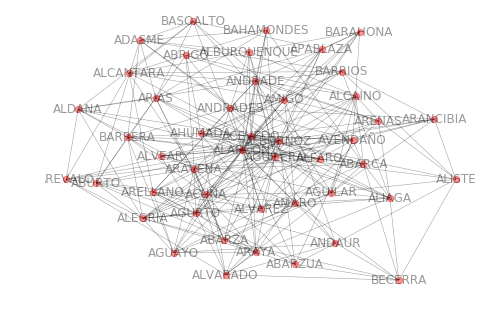

In [86]:
#Especificamos la tabla para ploteo
overexpected = 100
n_surname = 5
n_tie = 2
remove_nodes = 8

g = pares_ordered[pares_ordered['overexpected'] > overexpected]
g = g[g['count_paterno'] > n_surname]
g = g[g['count_materno'] > n_surname]
g = g[g['count_par'] > n_tie]

print('Used a k of', str(k), '(using overexpected above 1)')

#PLOTEAMOS
g_plot = nx.from_pandas_edgelist(g, source = 'paterno', target = 'materno', edge_attr = 'overexpected')
print('Initial graph has ' + str(g_plot.number_of_nodes()) + ' nodes')
print('Removed nodes below coreness ' + str(remove_nodes))
g_plot.remove_edges_from(nx.selfloop_edges(g_plot))
# remove = [node for node,degree in g_plot.degree() if degree < remove_nodes]
cores = nx.algorithms.core.core_number(g_plot)
nx.set_node_attributes(g_plot, cores, 'core')
remove = [x for x, y in g_plot.nodes(data = True) if y['core'] < remove_nodes]
g_plot.remove_nodes_from(remove)
g_plot = max(nx.connected_component_subgraphs(g_plot), key=len)
print('After prunning, the graph ended with ' + str(g_plot.number_of_nodes()) + ' nodes')

options_1 = {
    'node_color' : 'red',
    'node_size' : 40,
    'width': 0.5,
    'alpha': 0.4
}

pos = nx.spring_layout(g_plot)
nx.draw(g_plot, pos, with_labels = True, **options_1)
plt.show()

# plt.savefig('C:/Users/naimb/Desktop/Papers_y_Conferencias/AbstractTex/surname_plot.png',bbox_inches='tight')